In [1]:
import pandas as pd
from IPython.display import display
import numpy as np
import tensorflow as tf
from keras.layers import Dropout, Dense, BatchNormalization
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from sklearn import preprocessing
import keras
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline   

Using TensorFlow backend.


In [3]:
from keras import backend as K
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf 
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.8
set_session(tf.Session(config=config))
K.tensorflow_backend._get_available_gpus()

In [4]:
test_source = pd.read_csv('all/test_V2.csv')
train_source = pd.read_csv('all/train_V2.csv')


In [5]:
def clear_useless(train, test, useless):
    test_temp = test.drop(columns=useless)
    train_temp = train.drop(columns=useless)
    
    return train_temp, test_temp
useless = ['Id', 'groupId', 'matchType', 'matchId']
test_Id = test_source['Id']
train,test = clear_useless(train_source, test_source, useless)

name = ['assists', 'boosts', 'damageDealt', 
        'DBNOs', 'headshotKills', 'heals', 
        'killPlace', 'killPoints', 'kills', 
        'killStreaks', 'longestKill', 'matchDuration', 
        'maxPlace', 'numGroups', 'rankPoints', 
        'revives', 'rideDistance', 'roadKills', 
        'swimDistance', 'teamKills', 'vehicleDestroys', 
        'walkDistance', 'weaponsAcquired', 'winPoints', 'winPlacePerc']
print(train.isnull().sum().sum())
for i in name:
    print(train[train[i].isnull()])

train = train.drop(2744604)
print(train.isnull().sum().sum())
print(test.isnull().sum().sum())
display(train.head(10))

1
Empty DataFrame
Columns: [assists, boosts, damageDealt, DBNOs, headshotKills, heals, killPlace, killPoints, kills, killStreaks, longestKill, matchDuration, maxPlace, numGroups, rankPoints, revives, rideDistance, roadKills, swimDistance, teamKills, vehicleDestroys, walkDistance, weaponsAcquired, winPoints, winPlacePerc]
Index: []

[0 rows x 25 columns]
Empty DataFrame
Columns: [assists, boosts, damageDealt, DBNOs, headshotKills, heals, killPlace, killPoints, kills, killStreaks, longestKill, matchDuration, maxPlace, numGroups, rankPoints, revives, rideDistance, roadKills, swimDistance, teamKills, vehicleDestroys, walkDistance, weaponsAcquired, winPoints, winPlacePerc]
Index: []

[0 rows x 25 columns]
Empty DataFrame
Columns: [assists, boosts, damageDealt, DBNOs, headshotKills, heals, killPlace, killPoints, kills, killStreaks, longestKill, matchDuration, maxPlace, numGroups, rankPoints, revives, rideDistance, roadKills, swimDistance, teamKills, vehicleDestroys, walkDistance, weaponsAcqu

0
0


,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,0,0,0.000,0,0,0,60,1241,0,0,...,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,0,0,91.470,0,0,0,57,0,0,0,...,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1,0,68.000,0,0,0,47,0,0,0,...,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,0,0,32.900,0,0,0,75,0,0,0,...,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,0,0,100.000,0,0,0,45,0,1,1,...,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875
5,0,0,100.000,1,1,0,44,0,1,1,...,0,0.0000,0,0.00,0,0,34.70,1,0,0.0370
6,0,0,0.000,0,0,0,96,1262,0,0,...,0,0.0000,0,0.00,0,0,13.50,1,1497,0.0000
7,0,0,8.538,0,0,0,48,1000,0,0,...,0,2004.0000,0,0.00,0,0,1089.00,6,1500,0.7368
8,0,0,51.600,0,0,0,64,0,0,0,...,0,0.0000,0,0.00,0,0,799.90,4,0,0.3704
9,0,0,37.270,0,0,0,74,0,0,0,...,0,0.0000,0,0.00,0,0,65.67,1,0,0.2143


In [6]:
train_input = np.asarray(train.loc[:, train.columns != 'winPlacePerc'])
train_output = np.asarray(train.loc[:,'winPlacePerc'])
test_input = np.asarray(test)
train_output = train_output.reshape((train_output.shape[0], 1))

print('Train:\nInput: {}   |   Output: {}\n\nTest:\nInput: {}'.format(train_input.shape, train_output.shape, test_input.shape))

Train:
Input: (4446965, 24)   |   Output: (4446965, 1)

Test:
Input: (1934174, 24)


In [7]:
def scale_data(data):
    return preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit_transform(data)
    
train_input = scale_data(train_input)
test_input = scale_data(test_input)

split = int(np.ceil(train_input.shape[0]*0.9))
valid_input = train_input[split:,:]
train_input = train_input[:split,:]

valid_output = train_output[split:]
train_output = train_output[:split]
print('Train:\nInput: {}   |   Output: {}\n\nValid:\nInput: {}   |   Output: {}\n\nTest:\nInput: {}'.format(train_input.shape, train_output.shape, valid_input.shape, valid_output.shape, test_input.shape))

Train:
Input: (4002269, 24)   |   Output: (4002269, 1)

Valid:
Input: (444696, 24)   |   Output: (444696, 1)

Test:
Input: (1934174, 24)


In [8]:
train_input

array([[-1.        , -1.        , -1.        , ..., -0.98100853,
        -0.99152542,  0.45653254],
       [-1.        , -1.        , -0.97234885, ..., -0.88875097,
        -0.95762712, -1.        ],
       [-0.90909091, -1.        , -0.97944377, ..., -0.98744763,
        -0.98305085, -1.        ],
       ...,
       [-1.        , -0.87878788, -0.98600363, ..., -0.88642358,
        -0.96610169, -1.        ],
       [-1.        , -1.        , -1.        , ..., -0.99801164,
        -0.99152542, -1.        ],
       [-1.        , -0.93939394, -0.96438936, ..., -0.92381691,
        -0.97457627,  0.49031297]])

In [9]:
# https://gist.github.com/stared/dfb4dfaf6d9a8501cd1cc8b8cb806d2e
# Below is live plot
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.val_losses2 = []
        self.fig = plt.figure()
        self.logs = []
        self.avg_val_loss = 0
        self.total_epochs = self.params['epochs']

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.val_losses2.append(logs.get('val_loss'))
        self.avg_val_loss = np.mean(self.val_losses2)
        if self.i%10 == 0:
            self.val_losses2 = []
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.xlabel('Epochs')
        plt.ylabel('Losses')
        plt.show()
        print('Epoch {}/{}'.format(self.i, self.total_epochs))
        print('Last10_avg_Valid_loss = {}'.format(self.avg_val_loss))
        print('Training_loss = {}'.format(logs.get('loss')))

In [10]:
epochs = 100
batch_size = 10000

In [11]:
model = Sequential()

model.add(Dense(32, input_shape=(train_input.shape[1],), activation='relu'))
# model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(16, activation='relu'))
# model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(8, activation='relu'))
# model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                800       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 136       
_________________________________________________________________
dropout_3 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
Total para

In [12]:
optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0001)
optimizer = 'nadam'
model.compile(optimizer=optimizer, loss='mean_absolute_error')

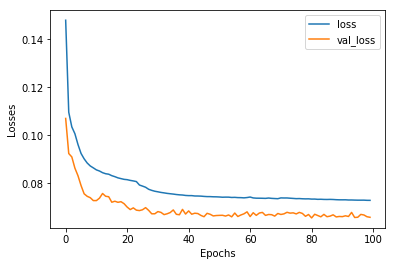

Epoch 100/100
Last10_avg_Valid_loss = 0.06637174354034883
Training_loss = 0.0728408023846522


In [13]:
model.fit(train_input, train_output, 
          validation_data=(valid_input, valid_output),
          epochs=epochs, batch_size=batch_size, callbacks=[PlotLosses()], verbose=1)

In [14]:
prediction = model.predict(test_input)

In [15]:
sub = {'Id': test_Id, 'winPlacePerc': prediction.reshape(1,-1)[0]}
submission = pd.DataFrame(data=sub)

In [16]:
submission.to_csv('submission.csv', index=False)